En el siguiente Notebook se realizará el trabajo de procesado de datos, y posteriormente el modelado y la discusión de sus resultados

In [1]:
"""
Real Estate Clustering Analysis
-------------------------------
This script performs data cleaning, exploratory analysis, and clustering
on a real estate dataset to identify market segments.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import make_scorer, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_and_clean_data(file_path):
    """
    Load and clean the real estate dataset
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file containing the dataset
        
    Returns:
    --------
    pandas.DataFrame
        Cleaned DataFrame
    """
    # Load data
    df = pd.read_csv(file_path)
    
    # Basic cleaning
    df.dropna(how='all', inplace=True)
    
    # Extract numeric values from area columns
    df['Area Privada'] = df['Area Privada'].str.extract('(\d+\.?\d*)').astype(float)
    df['Area'] = df['Area'].str.extract('(\d+\.?\d*)').astype(float)
    
    # Check and remove duplicates
    duplicate_ids = df['ID'].duplicated().sum()
    print(f"Number of duplicate IDs found: {duplicate_ids}")
    df = df.drop_duplicates(subset=['ID'], keep='first')
    print(f"Dataframe shape after removing duplicates: {df.shape}")
    
    # Handle categorical data
    df['Tipo de inmueble'] = df['Tipo de inmueble'].replace({
        'Apartaestudio': 'Apartamento',
        'Habitación': 'Apartamento'
    })
    
    # Handle missing values
    df['Parqueaderos'] = df['Parqueaderos'].fillna(0)
    df['Baños'] = df['Baños'].fillna(0)
    df['Estrato'] = df['Estrato'].fillna(df['Estrato'].mode()[0])
    df['Antiguedad'] = df['Antiguedad'].fillna(df['Antiguedad'].mode()[0])
    df['Habitaciones'] = df['Habitaciones'].fillna(1)
    df['Area Privada'] = df['Area Privada'].fillna(df['Area'].iloc[0])
    
    return df


In [3]:
def create_features(df):
    """
    Create additional features for analysis and modeling
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with additional features
    """
    # Create modeling DataFrame (remove non-modeling columns)
    model_df = df.drop(columns=['Descripción', 'Facilities', 'ID', 'Estado'])
    
    # Add price per square meter
    model_df['Precio_por_m2'] = model_df['Precio (admin_included)'] / model_df['Area']
    
    # Add bedroom-to-bathroom ratio
    model_df['Bedroom_Bath_Ratio'] = model_df['Habitaciones'] / model_df['Baños'].replace(0, 0.5)
    
    # Add categorical features for property size
    model_df['Size_Category'] = pd.cut(
        model_df['Area'], 
        bins=[0, 30, 60, 120, 500, float('inf')],
        labels=['Tiny', 'Small', 'Medium', 'Large', 'Huge']
    )
    model_df = pd.get_dummies(model_df, columns=['Size_Category'], drop_first=True)
    
    # Save original version for later analysis
    model_df_original = model_df.copy()
    
    # Convert categorical variables to dummy variables
    model_df = pd.get_dummies(model_df, columns=['Tipo de inmueble'], drop_first=True)
    model_df = pd.get_dummies(model_df, columns=['Antiguedad'], drop_first=True)
    
    return model_df, model_df_original


In [4]:
def scale_features(df, feature_columns):
    """
    Standardize numerical features
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    feature_columns : list
        List of column names to standardize
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with standardized features
    """
    scaler = StandardScaler()
    df[feature_columns] = scaler.fit_transform(df[feature_columns])
    return df


In [5]:
def evaluate_kmeans_clusters(df, features, k_range=range(2, 10)):
    """
    Evaluate the optimal number of clusters using silhouette score
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    features : list
        List of feature columns to use
    k_range : range
        Range of k values to evaluate
        
    Returns:
    --------
    int
        Optimal number of clusters
    list
        Silhouette scores for each k
    """
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(df[features])
        silhouette_avg = silhouette_score(df[features], clusters)
        silhouette_scores.append(silhouette_avg)
        print(f"For n_clusters = {k}, the silhouette score is {silhouette_avg}")
    
    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, 'o-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis For Optimal k')
    plt.grid(True)
    plt.show()
    
    # Choose optimal k (highest silhouette score)
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters: {optimal_k}")
    
    return optimal_k, silhouette_scores


In [6]:
def compare_clustering_algorithms(df, features, n_clusters=3):
    """
    Compare different clustering algorithms
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    features : list
        List of feature columns to use
    n_clusters : int
        Number of clusters to use
        
    Returns:
    --------
    dict
        Dictionary containing clustering results for each algorithm
    """
    results = {}
    
    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_clusters = kmeans.fit_predict(df[features])
    kmeans_score = silhouette_score(df[features], kmeans_clusters)
    results['KMeans'] = {
        'clusters': kmeans_clusters,
        'score': kmeans_score,
        'model': kmeans
    }
    
    # Gaussian Mixture Models
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_clusters = gmm.fit_predict(df[features])
    gmm_score = silhouette_score(df[features], gmm_clusters)
    results['GMM'] = {
        'clusters': gmm_clusters,
        'score': gmm_score,
        'model': gmm
    }
    
    # DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_clusters = dbscan.fit_predict(df[features])
    
    # Only calculate silhouette score if there's more than one cluster and no noise points (-1)
    if len(set(dbscan_clusters)) > 1 and -1 not in dbscan_clusters:
        dbscan_score = silhouette_score(df[features], dbscan_clusters)
        results['DBSCAN'] = {
            'clusters': dbscan_clusters,
            'score': dbscan_score,
            'model': dbscan
        }
    else:
        print("DBSCAN produced noise points or a single cluster. Adjust parameters.")
    
    # Hierarchical Clustering
    hc = AgglomerativeClustering(n_clusters=n_clusters)
    hc_clusters = hc.fit_predict(df[features])
    hc_score = silhouette_score(df[features], hc_clusters)
    results['Hierarchical'] = {
        'clusters': hc_clusters,
        'score': hc_score,
        'model': hc
    }
    
    # Print scores
    for algo, res in results.items():
        if 'score' in res:
            print(f"{algo} Silhouette Score: {res['score']}")
    
    return results


In [7]:
def visualize_clustering_results(df, features, clustering_results):
    """
    Visualize clustering results using PCA
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    features : list
        List of feature columns used for clustering
    clustering_results : dict
        Dictionary containing clustering results
    """
    # Apply PCA for visualization
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(df[features])
    
    # Create a figure with multiple subplots
    algorithms = list(clustering_results.keys())
    n_algos = len(algorithms)
    
    # Create a grid of subplots
    fig, axes = plt.subplots(2, (n_algos + 1) // 2, figsize=(15, 12))
    axes = axes.flatten()
    
    # Plot each algorithm's results
    for i, algo in enumerate(algorithms):
        if i < len(axes):
            axes[i].scatter(
                principal_components[:, 0], 
                principal_components[:, 1], 
                c=clustering_results[algo]['clusters'], 
                cmap='viridis'
            )
            axes[i].set_title(f'{algo} Clustering')
    
    plt.tight_layout()
    plt.show()
    
    # Compare the performance of different algorithms
    algorithms = [algo for algo in clustering_results.keys() if 'score' in clustering_results[algo]]
    scores = [clustering_results[algo]['score'] for algo in algorithms]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=algorithms, y=scores)
    plt.ylabel('Silhouette Score')
    plt.title('Clustering Algorithm Comparison')
    plt.ylim(0, max(scores) * 1.2)
    plt.show()


In [8]:
def fine_tune_kmeans(df, features):
    """
    Fine-tune KMeans using GridSearchCV
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    features : list
        List of feature columns to use
        
    Returns:
    --------
    KMeans
        Optimized KMeans model
    numpy.ndarray
        Cluster assignments
    """
    # Define parameter grid
    param_grid = {
        'n_clusters': range(2, 10),
        'init': ['k-means++', 'random'],
        'n_init': [10, 15, 20],
        'max_iter': [300, 500]
    }
    
    # Create a custom scorer
    # silhouette_scorer = make_scorer(silhouette_score, greater_is_better=True)
    silhouette_scorer = make_scorer(
        lambda est, X, y: silhouette_score(X, est.predict(X)), 
        greater_is_better=True
        )
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        KMeans(),
        param_grid,
        scoring=silhouette_scorer,
        cv=5  # Using 5-fold cross-validation
    )
    
    # Fit the model
    grid_search.fit(df[features])
    
    # Get the best parameters
    print("Best parameters:", grid_search.best_params_)
    print("Best silhouette score:", grid_search.best_score_)
    
    # Use the best model for final clustering
    best_kmeans = grid_search.best_estimator_
    final_clusters = best_kmeans.predict(df[features])
    
    # Evaluate with additional metrics
    db_score = davies_bouldin_score(df[features], final_clusters)
    print(f"Davies-Bouldin Score: {db_score}")
    
    ch_score = calinski_harabasz_score(df[features], final_clusters)
    print(f"Calinski-Harabasz Score: {ch_score}")
    
    return best_kmeans, final_clusters


In [9]:
def analyze_clusters(df, cluster_column='Cluster'):
    """
    Analyze the characteristics of each cluster
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with cluster assignments
    cluster_column : str
        Name of the column containing cluster assignments
        
    Returns:
    --------
    pandas.DataFrame
        Cluster profile data
    """
    # Number of properties in each cluster
    cluster_counts = df[cluster_column].value_counts().sort_index()
    print(f"Number of properties in each cluster:\n{cluster_counts}")
    
    # Create a profile for each numeric column
    numeric_cols = ['Precio (admin_included)', 'Area', 'Area Privada', 
                    'Estrato', 'Baños', 'Habitaciones', 'Parqueaderos', 'Piso']
    
    profile = df.groupby(cluster_column)[numeric_cols].agg(['mean', 'median', 'min', 'max', 'std'])
    print("\nCluster Profiles:")
    print(profile)
    
    # Distribution of categorical variables across clusters
    categorical_cols = ['Tipo de inmueble', 'Antiguedad']
    for col in categorical_cols:
        if col in df.columns:
            print(f"\nDistribution of {col} across clusters:")
            print(pd.crosstab(df[cluster_column], df[col], normalize='index'))
    
    return profile


In [10]:
def plot_cluster_profiles(df, numeric_cols, cluster_col='Cluster'):
    """
    Plot radar charts to visualize cluster profiles
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with cluster assignments
    numeric_cols : list
        List of numeric columns to include in the profile
    cluster_col : str
        Name of the column containing cluster assignments
    """
    # Get the number of clusters
    n_clusters = df[cluster_col].nunique()
    
    # Calculate the mean of each feature for each cluster
    means = df.groupby(cluster_col)[numeric_cols].mean()
    
    # Scale the data between 0 and 1 for radar chart
    scaler = StandardScaler()
    means_scaled = pd.DataFrame(
        scaler.fit_transform(means),
        index=means.index,
        columns=means.columns
    )
    
    # Create a radar chart for each cluster
    fig, axes = plt.subplots(1, n_clusters, figsize=(15, 5), subplot_kw=dict(polar=True))
    if n_clusters == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        values = means_scaled.iloc[i].values
        angles = np.linspace(0, 2*np.pi, len(numeric_cols), endpoint=False).tolist()
        values = np.concatenate((values, [values[0]]))  # Close the loop
        angles = np.concatenate((angles, [angles[0]]))  # Close the loop
        
        ax.plot(angles, values, 'o-', linewidth=2)
        ax.fill(angles, values, alpha=0.25)
        ax.set_thetagrids(np.degrees(angles[:-1]), numeric_cols)
        ax.set_title(f'Cluster {i}')
    
    plt.tight_layout()
    plt.show()


In [11]:
def plot_boxplots(df, features, cluster_col='Cluster'):
    """
    Create boxplots for each feature by cluster
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with cluster assignments
    features : list
        List of features to plot
    cluster_col : str
        Name of the column containing cluster assignments
    """
    n_features = len(features)
    fig, axes = plt.subplots(n_features, 1, figsize=(10, 4*n_features))
    
    if n_features == 1:
        axes = [axes]
    
    for i, feature in enumerate(features):
        sns.boxplot(x=cluster_col, y=feature, data=df, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature} by Cluster')
    
    plt.tight_layout()
    plt.show()


In [12]:
def test_cluster_differences(df, features, cluster_col='Cluster'):
    """
    Run statistical tests to confirm differences between clusters
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with cluster assignments
    features : list
        List of features to test
    cluster_col : str
        Name of the column containing cluster assignments
        
    Returns:
    --------
    pandas.DataFrame
        Test results
    """
    results = {}
    n_clusters = df[cluster_col].nunique()
    
    for feature in features:
        # For features with 2 clusters, use t-test
        if n_clusters == 2:
            cluster_0 = df[df[cluster_col] == 0][feature]
            cluster_1 = df[df[cluster_col] == 1][feature]
            t_stat, p_val = stats.ttest_ind(cluster_0, cluster_1, equal_var=False)
            results[feature] = {'test': 't-test', 'statistic': t_stat, 'p_value': p_val}
        # For more than 2 clusters, use ANOVA
        else:
            groups = [df[df[cluster_col] == i][feature] for i in range(n_clusters)]
            f_stat, p_val = stats.f_oneway(*groups)
            results[feature] = {'test': 'ANOVA', 'statistic': f_stat, 'p_value': p_val}
    
    return pd.DataFrame(results).T


In [13]:
def label_clusters(profile):
    """
    Assign business-friendly labels to clusters based on their characteristics
    
    Parameters:
    -----------
    profile : pandas.DataFrame
        Cluster profile data
        
    Returns:
    --------
    dict
        Mapping of cluster index to label
    """
    cluster_labels = {}
    
    # Calculate average price and area across all clusters to use as thresholds
    avg_price = profile[('Precio (admin_included)', 'mean')].mean()
    avg_area = profile[('Area', 'mean')].mean()
    
    for cluster in profile.index:
        # Extract key metrics for this cluster
        price = profile.loc[cluster, ('Precio (admin_included)', 'mean')]
        area = profile.loc[cluster, ('Area', 'mean')]
        rooms = profile.loc[cluster, ('Habitaciones', 'mean')]
        
        # Logic to assign labels based on property characteristics
        if price > avg_price:
            price_label = "Premium"
        else:
            price_label = "Budget"
            
        if area > avg_area:
            size_label = "Spacious"
        else:
            size_label = "Compact"
            
        cluster_labels[cluster] = f"{price_label} {size_label} Properties"
    
    return cluster_labels


In [14]:
def visualize_pca_clusters(df, features, clusters, centers=None):
    """
    Visualize clusters using PCA
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    features : list
        List of feature columns used for clustering
    clusters : numpy.ndarray
        Cluster assignments
    centers : numpy.ndarray, optional
        Cluster centers (for KMeans)
    """
    # Apply PCA for visualization
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(df[features])
    
    plt.figure(figsize=(8, 6))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title('Cluster Visualization with PCA')
    plt.colorbar(label='Cluster')
    
    # Add cluster centers if provided
    if centers is not None:
        centers_pca = pca.transform(centers)
        plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=100, marker='X')
    
    plt.show()


In [15]:
def analyze_correlations(df):
    """
    Analyze correlations between features
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame with features
    """
    corr_matrix = df.corr()
    print("Correlations with Price:")
    print(corr_matrix['Precio (admin_included)'].sort_values(ascending=False))
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()


In [16]:
def analyze_feature_importance(df, target='Precio (admin_included)'):
    """
    Analyze feature importance for predicting price
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    target : str
        Target variable (price)
    """
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.preprocessing import StandardScaler
    
    # Prepare data
    X = df.drop(columns=[target, 'Cluster', 'Market_Segment'])
    y = df[target]
    
    # Handle categorical variables
    X = pd.get_dummies(X, drop_first=True)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train a random forest model
    model = RandomForestRegressor(random_state=42)
    model.fit(X_scaled, y)
    
    # Get feature importance
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("Feature importance for price prediction:")
    print(importance.head(10))
    
    # Visualize
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance.head(10))
    plt.title('Top 10 Features Impacting Price')
    plt.show()
    
    return importance

def analyze_price_by_cluster(df, cluster_col='Cluster'):
    """
    Analyze how price varies across clusters
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with cluster assignments
    cluster_col : str
        Name of the column containing cluster assignments
    """
    # Price statistics by cluster
    price_stats = df.groupby(cluster_col)['Precio (admin_included)'].agg(['mean', 'median', 'std', 'min', 'max'])
    print("Price statistics by cluster:")
    print(price_stats)
    
    # Visualize price distribution by cluster
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=cluster_col, y='Precio (admin_included)', data=df)
    plt.title('Price Distribution by Cluster')
    plt.ylabel('Price')
    plt.xlabel('Cluster')
    plt.show()
    
    return price_stats

In [17]:
def main():
    """Main function to run the analysis"""
    # Load and clean data
    file_path = 'dataset.csv'
    df = load_and_clean_data(file_path)
    
    # Create features
    model_df, model_df_original = create_features(df)
    
    # Define features for clustering
    features = ['Precio (admin_included)', 'Area Privada', 'Area', 'Estrato', 
                'Baños', 'Habitaciones', 'Piso']
    
    # Scale features
    model_df = scale_features(model_df, features)
    
    # Find optimal number of clusters
    optimal_k, _ = evaluate_kmeans_clusters(model_df, features)
    
    # Compare different clustering algorithms
    clustering_results = compare_clustering_algorithms(model_df, features, n_clusters=optimal_k)
    
    # Visualize clustering results
    visualize_clustering_results(model_df, features, clustering_results)
    
    # Fine-tune KMeans
    best_kmeans, final_clusters = fine_tune_kmeans(model_df, features)
    
    # Add clusters to original dataframe
    model_df_original['Cluster'] = final_clusters
    
    # Analyze clusters
    profile = analyze_clusters(model_df_original)
    
    # Visualize cluster profiles
    plot_features = ['Precio (admin_included)', 'Area', 'Estrato', 'Baños', 'Habitaciones', 'Parqueaderos']
    plot_cluster_profiles(model_df_original, plot_features)
    
    # Create boxplots for key features
    key_features = ['Precio (admin_included)', 'Area', 'Habitaciones', 'Estrato']
    plot_boxplots(model_df_original, key_features)
    
    # Scatter plot matrix
    sns.pairplot(model_df_original, 
                 vars=['Precio (admin_included)', 'Area', 'Habitaciones', 'Baños'], 
                 hue='Cluster', 
                 palette='viridis')
    plt.suptitle('Scatter Plot Matrix by Cluster', y=1.02)
    plt.show()
    
    # Statistical tests
    stat_results = test_cluster_differences(model_df_original, key_features)
    print("\nStatistical Tests for Cluster Differences:")
    print(stat_results)
    
    # Market segment labeling
    cluster_labels = label_clusters(profile)
    print("\nCluster Market Segments:")
    for cluster, label in cluster_labels.items():
        print(f"Cluster {cluster}: {label}")
    
    # Add labels to dataframe
    model_df_original['Market_Segment'] = model_df_original['Cluster'].map(cluster_labels)
    
    # Display sample of final dataset
    print("\nSample of segmented properties:")
    print(model_df_original[['Tipo de inmueble', 'Precio (admin_included)', 'Area', 
                           'Habitaciones', 'Cluster', 'Market_Segment']].head(10))
    
    # Visualize clusters with PCA
    visualize_pca_clusters(model_df, features, final_clusters, best_kmeans.cluster_centers_)
    
    # Analyze correlations
    analyze_correlations(model_df)
    # Feature importance for price
    importance = analyze_feature_importance(model_df_original)

    print(importance)
    
    # Save final results
    model_df_original.to_csv('real_estate_segments.csv', index=False)
    print("Analysis complete. Results saved to 'real_estate_segments.csv'")


Number of duplicate IDs found: 0
Dataframe shape after removing duplicates: (594, 14)
For n_clusters = 2, the silhouette score is 0.5350571570008068
For n_clusters = 3, the silhouette score is 0.5269820745184624
For n_clusters = 4, the silhouette score is 0.34717431807636123
For n_clusters = 5, the silhouette score is 0.3545222439692743
For n_clusters = 6, the silhouette score is 0.3602321823810078
For n_clusters = 7, the silhouette score is 0.36662295544876755
For n_clusters = 8, the silhouette score is 0.3836718232550033
For n_clusters = 9, the silhouette score is 0.38450713069750936


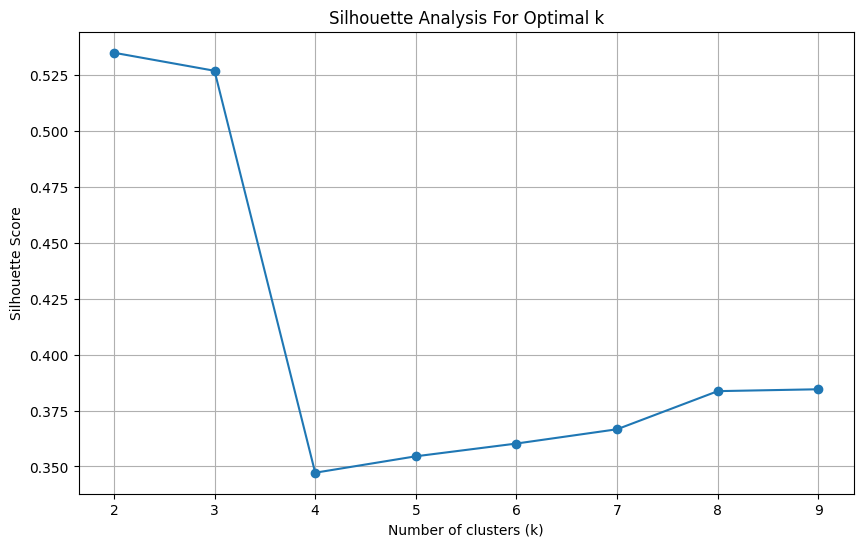

Optimal number of clusters: 2
DBSCAN produced noise points or a single cluster. Adjust parameters.
KMeans Silhouette Score: 0.5350571570008068
GMM Silhouette Score: 0.34579128979626605
Hierarchical Silhouette Score: 0.5226185927296864


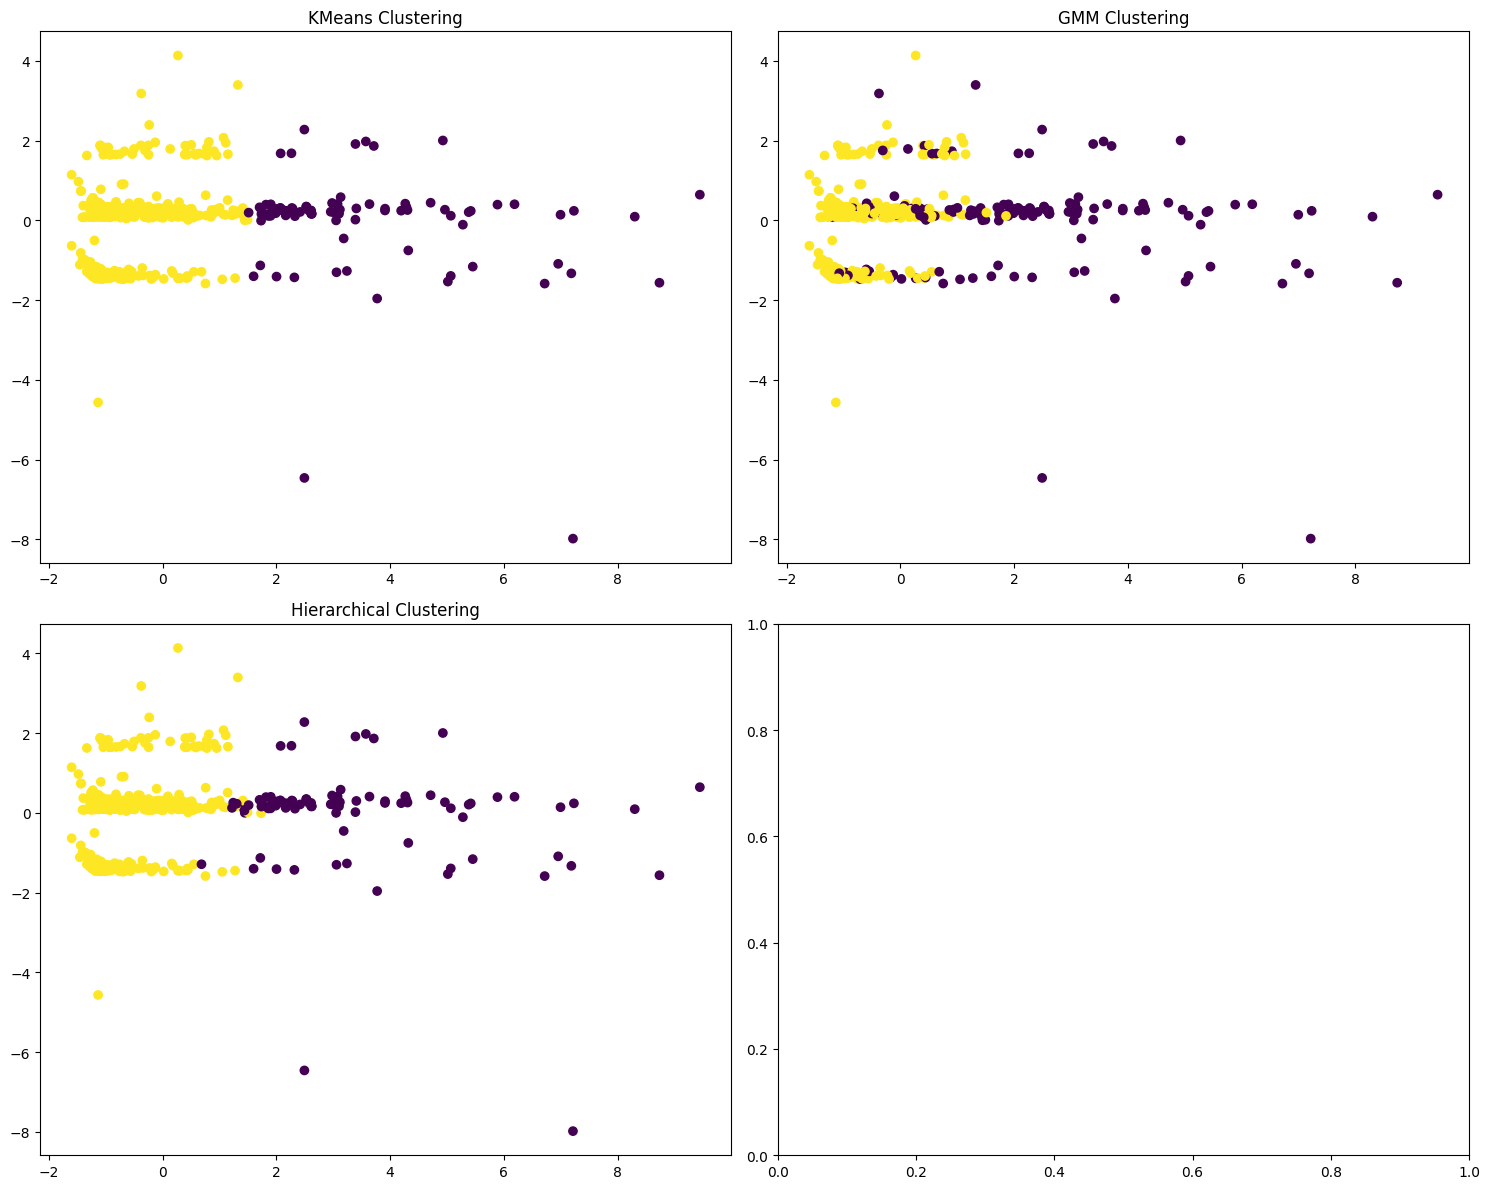

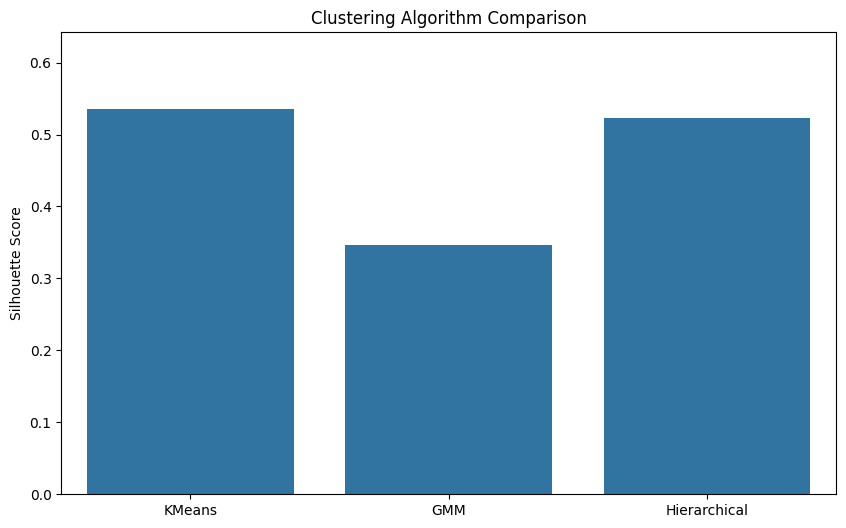

Best parameters: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10}
Best silhouette score: nan
Davies-Bouldin Score: 1.0839082064066552
Calinski-Harabasz Score: 267.89173546375105
Number of properties in each cluster:
Cluster
0     88
1    506
Name: count, dtype: int64

Cluster Profiles:
        Precio (admin_included)                                    \
                           mean     median       min          max   
Cluster                                                             
0                  2.267222e+07  6500000.0   50000.0  770000000.0   
1                  2.118777e+06  1700000.0  300000.0   18500000.0   

                             Area                                 ...  \
                  std        mean median  min    max         std  ...   
Cluster                                                           ...   
0        9.440750e+07  360.977273  352.0  1.0  960.0  177.461667  ...   
1        1.698878e+06   55.285968   36.0  1.0  510.0  

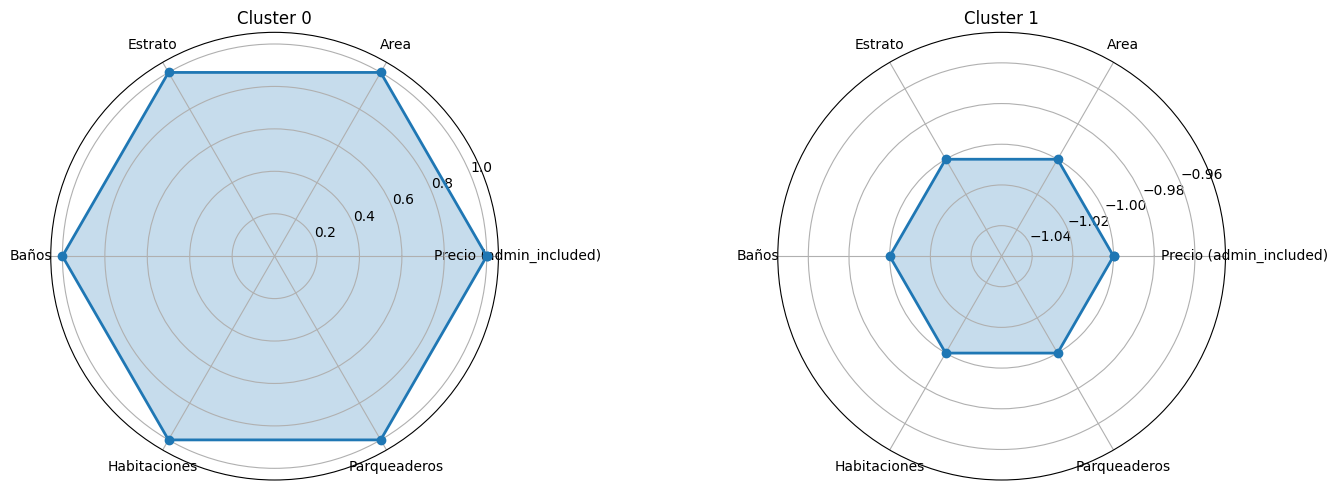

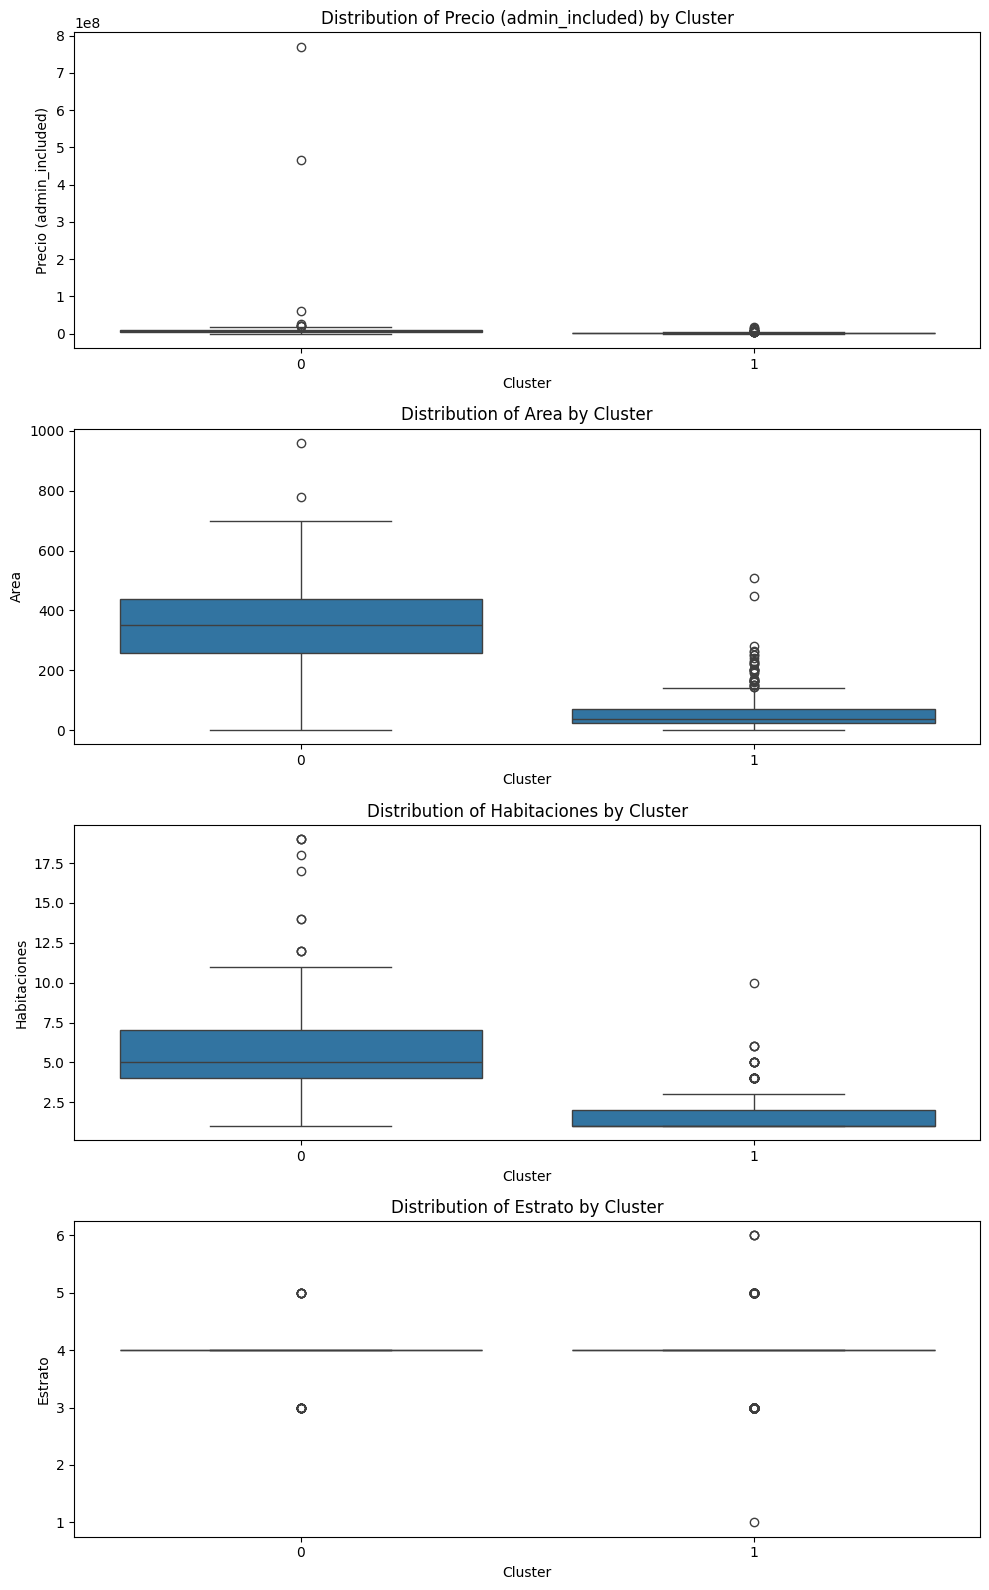

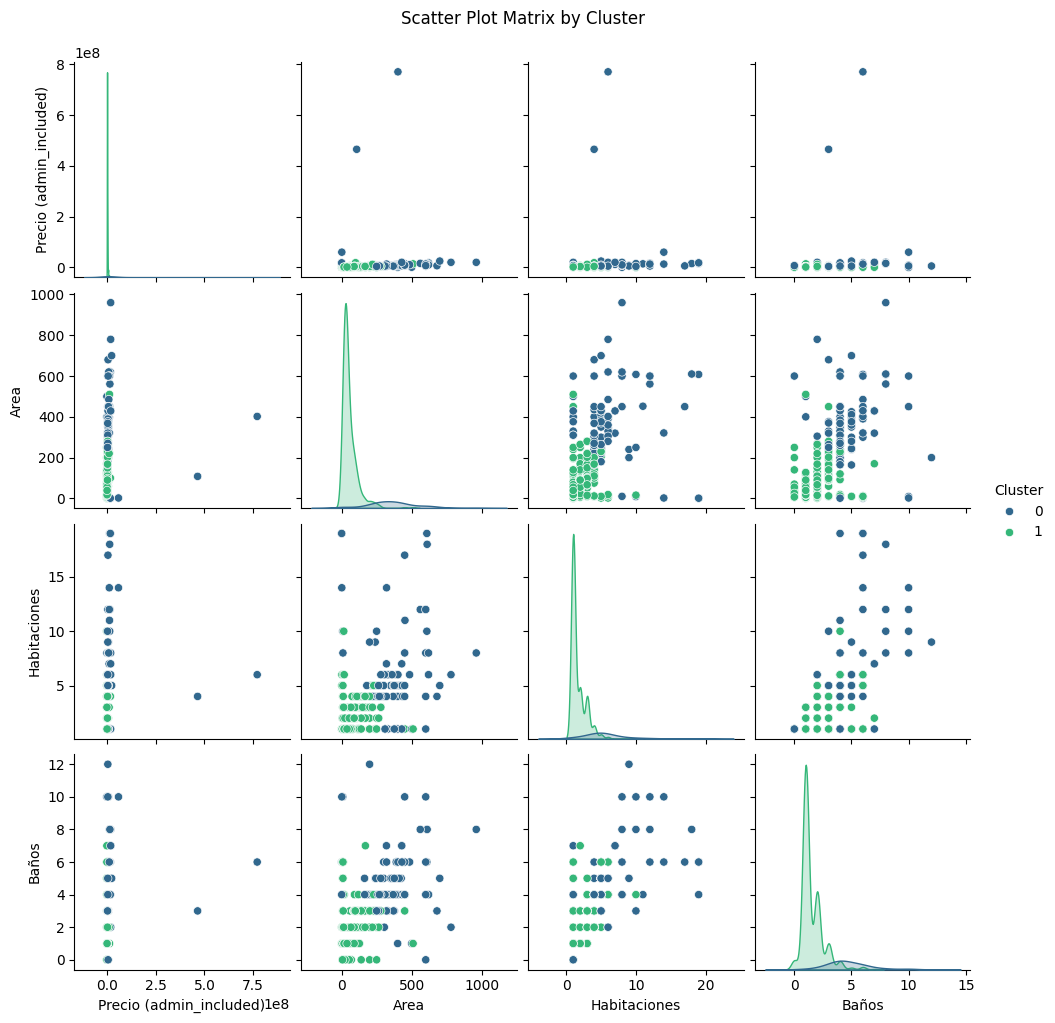


Statistical Tests for Cluster Differences:
                           test  statistic   p_value
Precio (admin_included)  t-test   2.042242  0.044155
Area                     t-test  16.023494       0.0
Habitaciones             t-test  10.304635       0.0
Estrato                  t-test   0.738012  0.461795

Cluster Market Segments:
Cluster 0: Premium Spacious Properties
Cluster 1: Budget Compact Properties

Sample of segmented properties:
   Tipo de inmueble  Precio (admin_included)   Area  Habitaciones  Cluster  \
0       Apartamento                1800000.0   22.0           1.0        1   
1       Apartamento                3500000.0   31.0           1.0        1   
2       Apartamento                1050000.0   45.0           1.0        1   
3       Apartamento                3500000.0   68.2           2.0        1   
4       Apartamento                1281000.0   17.0           1.0        1   
6       Apartamento                1450000.0   26.0           1.0        1   
8         

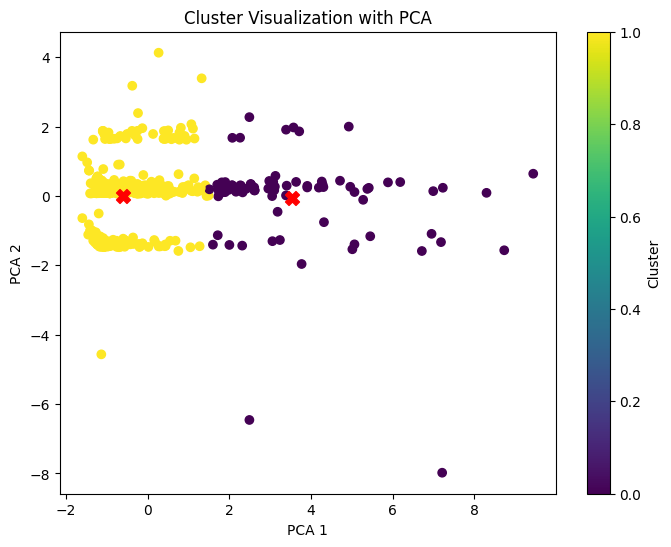

Correlations with Price:
Precio (admin_included)      1.000000
Baños                        0.162788
Precio_por_m2                0.154236
Area Privada                 0.150954
Area                         0.145256
Habitaciones                 0.135333
Tipo de inmueble_Casa        0.134625
Parqueaderos                 0.132018
Size_Category_Large          0.100710
Antiguedad_más de 30 años    0.061318
Size_Category_Huge           0.039059
Antiguedad_9 a 15 años       0.032484
Size_Category_Medium         0.028027
Bedroom_Bath_Ratio           0.017675
Estrato                     -0.015514
Piso                        -0.017593
Antiguedad_menor a 1 año    -0.029270
Antiguedad_16 a 30 años     -0.029851
Size_Category_Small         -0.051850
Name: Precio (admin_included), dtype: float64


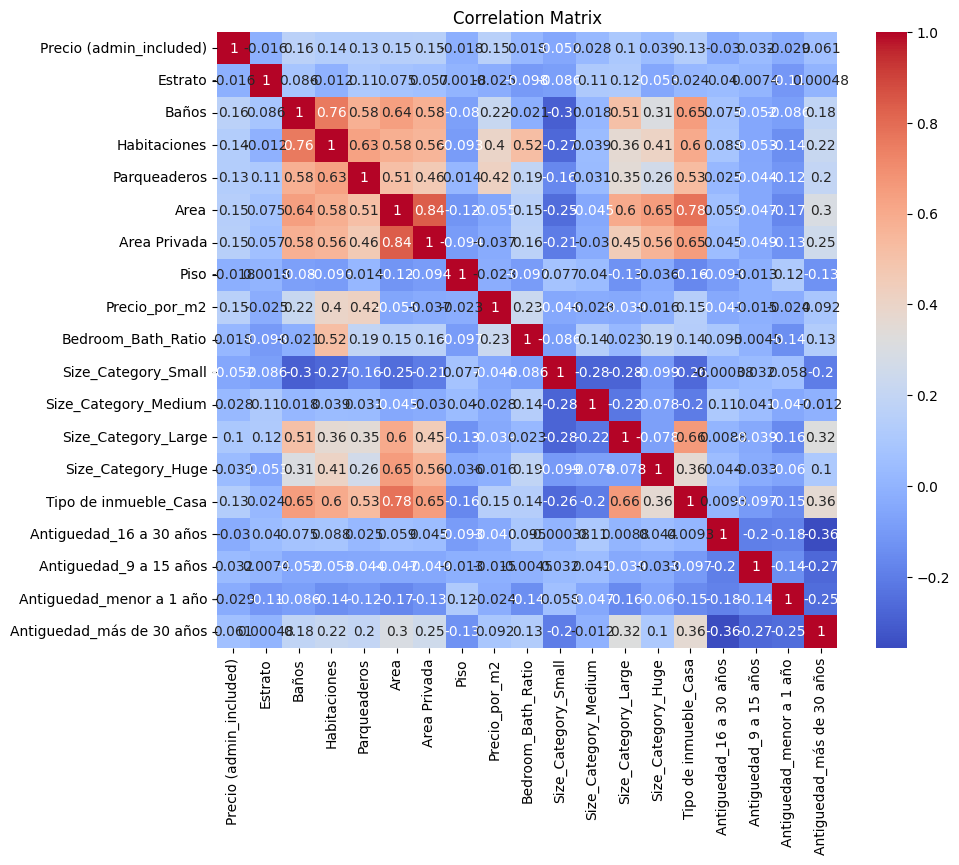

Feature importance for price prediction:
                   Feature  Importance
7            Precio_por_m2    0.507724
5             Area Privada    0.071601
13   Tipo de inmueble_Casa    0.068515
3             Parqueaderos    0.061824
2             Habitaciones    0.056319
4                     Area    0.055681
8       Bedroom_Bath_Ratio    0.050186
1                    Baños    0.030724
11     Size_Category_Large    0.024896
15  Antiguedad_9 a 15 años    0.022615


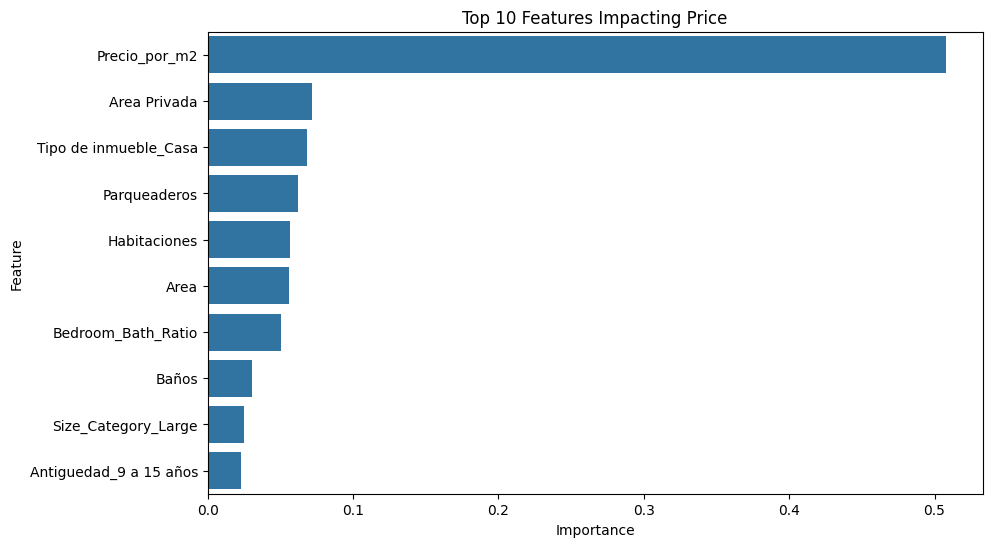

                      Feature  Importance
7               Precio_por_m2    0.507724
5                Area Privada    0.071601
13      Tipo de inmueble_Casa    0.068515
3                Parqueaderos    0.061824
2                Habitaciones    0.056319
4                        Area    0.055681
8          Bedroom_Bath_Ratio    0.050186
1                       Baños    0.030724
11        Size_Category_Large    0.024896
15     Antiguedad_9 a 15 años    0.022615
10       Size_Category_Medium    0.019853
17  Antiguedad_más de 30 años    0.013185
6                        Piso    0.010067
0                     Estrato    0.006205
12         Size_Category_Huge    0.000356
9         Size_Category_Small    0.000124
14    Antiguedad_16 a 30 años    0.000108
16   Antiguedad_menor a 1 año    0.000018
Analysis complete. Results saved to 'real_estate_segments.csv'


In [18]:
if __name__ == "__main__":
    main()